<div style="text-align: right"> Brian Boonstra </div>

<left>FINM 33150 - Regression and Quantitative Trading Strategies</left> 
<br>
<left>Winter 2022</left>

<h2><center> Homework 5 - FX Carry Strategy </center></h2>

<center>Due on Thursday, Feb 17</center>

<h3><span style="color:#00008B">Solution - Piyush Kontu</span></h3>

<h3><span style="color:#00008B">StudentId - 12284351 </span></h3>

<h3><span style="color:#00008B">Email - pkontu@uchicago.edu</span></h3>

## Objectives

- #### Data

    - Obtain 1M (0.08Y) rates for UK overnight index swaps (OIS) along with spot rates for the dollar versus pound.    
    - Obtain yield curves and FX rates of South African Rand, Thai Baht, Pakistani Rupee and Philippine Peso from the earliest possible date through now
    - There might be a need to interpolate from sparser data in some cases. (Not all maturities are available in all currencies.) <br><br>

- ####  Exercise
    - Synthesize an approximate PL of weekly-traded cross-currency fixed-float swaps from the Libor rates and swap curves, normalized to have a USD notional of 10MM at the beginning of each week.
    - To keep bugs out of our cash flow tracking, we will convert flows to USD, though in some cases doing so is super superfluous.<br><br>

- #### Fixed-Float Carry
    - In the borrowing (funding) currency, assume a rate of OIS+50bp, paid on 4/5 the notional amount (5x leverage) in the borrowing currency for each active position. In the lending currency, assume the schedule has a coupon every quarter at the 5Y swap rate, or (optionally) the 5Y treasury rate.
    - Weeks in which the 5Y swap rate of the borrow currency is less than 50bp higher than the 5Y swap rate in the funding currency will be assumed to have no position
    - At the end of each week, assume you sell out of the position before opening a new one. 
    - You therefore need to tally accrued interest at the borrow and lend rates, and then compute mark-to-market for the swap exit.<br><br>

- #### Lending Currency
    - ##### Mark to Market

        - Mark-to-market losses (due to swap rate and exchange rate changes) are the main source of downside deviation in this strategy.
        - Your original bond yield is the 5Y swap rate $s_{5}$, as are the coupons. Use the new swap curve to form a corresponding zero-coupon bond curve, and reprice the bond (with its original coupons equal to $s_{5}$) on the new interest rate curve, with the time remaining to all payments reduced by 1 week (or $\frac{1}{52}$ of a year).
        - This is then converted (if necessary) to USD for buyback value at the new FX rate.<br><br>

- #### Borrowing Currency
    - ##### Mark to Market
        - Assume $\Delta V$ = 0, since the durations are so short. <br>
    - ##### Accrual
        - Our interest payment is one week at the funding rate, multiplied by our borrowed amount.
        - We borrowed the funding-currency equivalent of USD 8MM at the starting FX rate f.
        - We must now return that same amount of home currency at the new FX rate, plus 1 week of interest on it (also in home currency) at OIS + 50bp.

## Contents (TBC)
1) Importing Python Libraries <br>
2) Fetching Data from Quandl <br>
3) Data Cleanup and Manipulation <br><br>

11) Conculsion



### 1) Importing Required Python Libraries

In [4]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import quandl
import nasdaqdatalink
import pandas_datareader as dr
import functools
import seaborn as sns
import plotnine as p9
from scipy import stats
from scipy.stats import norm
import statsmodels.api as sm
import itertools
import matplotlib.dates as mdates

import warnings
warnings.filterwarnings("ignore")

plt.rcParams['figure.figsize']=[15, 6]

In [5]:
def get_quandl_data(database,table,start_dt,end_dt):
    """ 
        Returns a DataFrame with datapoints (spot FX rates/OIS spot rates etc.) from the given database and tables in QUANDL
        Inputs: 
            database - QUANDL database name.
            table- QUANDL table name
            start_dt - Start Date for the datapoint
            end_dt - End Date for the datapoint
        Output:
            usd_to_curr - DataFrame with datapoints (spot FX rates/OIS spot rates etc.)
    """
    usd_to_curr = quandl.get(database+'/'+table,start_date=start_dt, end_date=end_dt)
    return usd_to_curr

In [6]:
def interpolated_rates(zcb,tenor):
    times = np.arange(tenor, 0, step=-0.02)[::-1]
    rates = []
    for col in zcb.columns:
        sub = zcb[col]
        r = np.interp(times, sub.index.values, sub.values) # Linear interpolation
        rates.append(pd.DataFrame([r], index= [col]))
    df = pd.concat(rates)
    df.columns = np.around(times, decimals=2)
    return df

In [7]:
def compute_zcb_curve(spot_rates_curve):
    zcb_rates = spot_rates_curve.copy()
    for curve in spot_rates_curve.columns:
        spot = spot_rates_curve[curve]
        for tenor, spot_rate in spot.iteritems():
            if tenor>0.001:
                times = np.arange(tenor-0.5, 0, step=-0.5)[::-1]
                coupon_half_yr = 0.5*spot_rate
                z = np.interp(times, zcb_rates[curve].index.values, zcb_rates[curve].values) # Linear interpolation
                preceding_coupons_val = (coupon_half_yr*np.exp(-z*times)).sum()
                zcb_rates[curve][tenor] = -np.log((1-preceding_coupons_val)/(1+coupon_half_yr))/tenor
    return zcb_rates

In [8]:
def create_carry_trade(lending_yc,borrowing_yc,borrowing_rates,yield_lst,yield_num_lst,lending_fx,borrowing_fx,swap_notional,borrow_frac,lending_tenor,zcb):
    
    borrow = swap_notional * borrow_frac
    
    if not zcb:
        weekly_yc_data = lending_yc.resample('W-WED').ffill().loc[:,yield_lst]
        weekly_yc_data.columns = yield_num_lst
        weekly_yc_zcb_data = compute_zcb_curve(weekly_yc_data.T/100).T
    
    else:
        weekly_yc_data = lending_yc
        weekly_yc_zcb_data = lending_yc
    
    weekly_interpolated_rates = interpolated_rates(weekly_yc_zcb_data.T,lending_tenor)
    weekly_yc_zcb_data = weekly_yc_zcb_data.merge(weekly_interpolated_rates.loc[:,round((lending_tenor-1 +(51/52)),2)], how = 'left',left_on = weekly_yc_zcb_data.index, right_on = weekly_interpolated_rates.index).set_index('key_0')
    weekly_yc_zcb_data.index.name = 'Date'
    
    weekly_yc_gbp_data = borrowing_yc.resample('W-WED').ffill().loc[weekly_yc_data.index.min():weekly_yc_data.index.max(),['5-Year']]
    weekly_yc_zcb_data = weekly_yc_zcb_data.merge(weekly_yc_gbp_data, how = 'left',left_on = weekly_yc_zcb_data.index, right_on = weekly_yc_gbp_data.index)\
                                    .rename(columns = {'5-Year':'gbp_5Y_rate'}).set_index('key_0')
    weekly_yc_zcb_data.index.name = 'Date'

    weekly_yc_zcb_data = weekly_yc_zcb_data.merge(lending_fx, how = 'left', left_on = weekly_yc_zcb_data.index, right_on = lending_fx.index)
    weekly_yc_zcb_data = weekly_yc_zcb_data.rename(columns={'RATE':'lend_fx_from_usd'}).set_index('key_0')
    weekly_yc_zcb_data['lend_fx_from_usd'] = weekly_yc_zcb_data['lend_fx_from_usd'].ffill()
    weekly_yc_zcb_data.index.name = 'Date'
    
    weekly_yc_zcb_data['Position'] = (weekly_yc_zcb_data[5] > (weekly_yc_zcb_data['gbp_5Y_rate'] + 0.5)/100).astype(int)
    weekly_yc_zcb_data['bonds_held'] = round((swap_notional * weekly_yc_zcb_data['lend_fx_from_usd'] * weekly_yc_zcb_data['Position'])\
                                                / np.exp(-weekly_yc_zcb_data[5] * 5),2)
    weekly_yc_zcb_data['ending_bond_value'] = weekly_yc_zcb_data['bonds_held']* np.exp(-weekly_yc_zcb_data.shift(-1)[round((lending_tenor-1) +(51/52),2)] * ((lending_tenor-1) +(51/52)))


    weekly_ois_data = borrowing_rates.resample('W-WED').ffill().loc[weekly_yc_data.index.min():weekly_yc_data.index.max()]
    weekly_ois_data = weekly_ois_data.merge(borrowing_fx, how = 'left', left_on = weekly_ois_data.index, right_on = borrowing_fx.index)

    weekly_ois_data = weekly_ois_data.rename(columns={'RATE':'gbp_fx_from_usd'}).set_index('key_0')
    weekly_ois_data.index.name = 'Date'
    
    weekly_ois_data['initial_borrow_gbp'] = borrow * weekly_ois_data['gbp_fx_from_usd']
    weekly_ois_data['interest_paid_usd'] = (((weekly_ois_data['1m_OIS_rate'] + 0.5)*0.01*7)/360) * (weekly_ois_data['initial_borrow_gbp'] )#/weekly_ois_data['fx_rate_from_usd'])
    
    weekly_yc_zcb_data = weekly_yc_zcb_data.merge(weekly_ois_data.loc[:,['interest_paid_usd','initial_borrow_gbp','gbp_fx_from_usd']], how = 'inner', left_on = weekly_yc_zcb_data.index, \
                                              right_on = weekly_ois_data.index).set_index('key_0')
    weekly_yc_zcb_data.index.name = 'Date'

    weekly_yc_zcb_data['ending_usd_value'] = (weekly_yc_zcb_data['ending_bond_value']/weekly_yc_zcb_data.shift(-1)['lend_fx_from_usd'])
    weekly_yc_zcb_data['usd_payable'] = weekly_yc_zcb_data['Position'] * (weekly_yc_zcb_data['interest_paid_usd'] + weekly_yc_zcb_data['initial_borrow_gbp'])/weekly_yc_zcb_data.shift(-1)['gbp_fx_from_usd']
    
    
    weekly_yc_zcb_data['weekly_usd_pnl'] = weekly_yc_zcb_data['Position'] *( weekly_yc_zcb_data['ending_usd_value'] - weekly_yc_zcb_data['usd_payable'] - ((1-borrow_frac) * swap_notional))

    weekly_yc_zcb_data['cum_pnl_usd'] = round(weekly_yc_zcb_data['weekly_usd_pnl'].cumsum(),3)
    weekly_yc_zcb_data['weekly_returns'] = weekly_yc_zcb_data['cum_pnl_usd'].diff() / weekly_yc_zcb_data['cum_pnl_usd'].abs().shift()
    #weekly_yc_zcb_data['weekly_returns'] = weekly_yc_zcb_data['cum_pnl_usd'].pct_change()
    weekly_yc_zcb_data['return_on_capital'] = weekly_yc_zcb_data['cum_pnl_usd']/((1-borrow_frac) * swap_notional)
    
    return weekly_yc_zcb_data


In [9]:
def performance_summary(return_data):
    """ 
        Returns the Performance Stats for given set of returns
        Inputs: 
            return_data - DataFrame with Date index and Monthly Returns for different assets/strategies.
        Output:
            summary_stats - DataFrame with annualized mean return, vol, sharpe ratio. Skewness, Excess Kurtosis, Var (0.5) and
                            CVaR (0.5) and drawdown based on weekly returns. 
    """
    summary_stats = return_data.mean().to_frame('Mean').apply(lambda x: x*52)
    summary_stats['Volatility'] = return_data.std().apply(lambda x: x*np.sqrt(52))
    summary_stats['Sharpe Ratio'] = summary_stats['Mean']/summary_stats['Volatility']
    
    summary_stats['Skewness'] = return_data.skew()
    summary_stats['Excess Kurtosis'] = return_data.kurtosis()
    summary_stats['VaR (0.05)'] = return_data.quantile(.05, axis = 0)
    summary_stats['CVaR (0.05)'] = return_data[return_data <= return_data.quantile(.05, axis = 0)].mean()
    summary_stats['Min'] = return_data.min()
    summary_stats['Max'] = return_data.max()
    
    wealth_index = 1000*(1+return_data).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks)/previous_peaks

    summary_stats['Max Drawdown'] = drawdowns.min()
    summary_stats['Peak'] = [previous_peaks[col][:drawdowns[col].idxmin()].idxmax() for col in previous_peaks.columns]
    summary_stats['Bottom'] = drawdowns.idxmin()
    
    recovery_date = []
    for col in wealth_index.columns:
        prev_max = previous_peaks[col][:drawdowns[col].idxmin()].max()
        recovery_wealth = pd.DataFrame([wealth_index[col][drawdowns[col].idxmin():]]).T
        recovery_date.append(recovery_wealth[recovery_wealth[col] >= prev_max].index.min())
    summary_stats['Recovery'] = recovery_date
    
    return summary_stats

In [10]:
def plot_return_distribution(return_df_lst, mappping_dict):
    fig, axs = plt.subplots(4, 1, figsize=(30, 30))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

    for i in range(0,len(lst)):
        mean = lst[i]['weekly_returns'].mean()
        vol = lst[i]['weekly_returns'].std()
        median = np.median(lst[i].fillna(0)['weekly_returns'])

        min_ret = lst[i].fillna(0)['weekly_returns'].min()    
        max_ret = lst[i].fillna(0)['weekly_returns'].max()

        textstrmin = r'$\mathrm{min \ return}=%.4f$' % (min_ret, )

        textstrmax = r'$\mathrm{max \ return}=%.4f$' % (max_ret,)

        textstr = '\n'.join((
                r'weekly $\mu=%.4f$' % (mean, ),
                r'weekly $\mathrm{median}=%.4f$' % (median,),
                r'weekly $\sigma=%.4f$' % (vol, )))

        axs[i].text(0.01, 0.95, textstr, transform=axs[i].transAxes, fontsize=25,
                verticalalignment='top', bbox=props)

        axs[i].text(0.01, 0.05, textstrmin, transform=axs[i].transAxes, fontsize=25,
                verticalalignment='bottom', bbox=props)

        axs[i].text(0.85, 0.05, textstrmax, transform=axs[i].transAxes, fontsize=25,
                verticalalignment='bottom', bbox=props)

        axs[i].hist(lst[i]['weekly_returns'], bins=100, density=True)
        axs[i].axvline(mean, c='r')
        axs[i].axvline(mean+vol, c='r')
        axs[i].axvline(mean-vol,c='r')
        axs[i].set_title(mappping_dict[i]+' Return Distribution', size=25)
        axs[i].set_xlabel('Return', size=18)
        axs[i].set_ylabel('Density', size=18)

        x = np.linspace(mean-3*vol, mean+3*vol, 100)
        p = norm.pdf(x, mean, vol)

        axs[i].plot(x, p, 'k', linewidth=2)
        axs[i].yaxis.grid(color='darkgray', linestyle='dashed')
        axs[i].xaxis.grid(color='darkgray', linestyle='dashed')

    fig.tight_layout()

In [11]:
def plot_rolling_tail_risk(window,currency,carry_trade_data,title):
    fig, axs = plt.subplots(len(carry_trade_data), 1, figsize=(30, 40))
    
    for i in range(0,len(carry_trade_data)):
        rolling_tail = pd.DataFrame(index= php_carry_trade.index)
        rolling_tail[currency[i]+'_'+str(window)+'d_Skewness'] = carry_trade_data[i].loc[:,['weekly_returns']].ffill().rolling(window=window).skew()
        rolling_tail[currency[i]+'_'+str(window)+'d_Kurtosis'] = carry_trade_data[i].loc[:,['weekly_returns']].ffill().rolling(window=window).kurt()

        axs[i].plot(rolling_tail)
        axs[i].set_xlabel('Date', size=25)
        axs[i].set_ylabel('Tail Measure', size=25)
        axs[i].legend(rolling_tail.columns,prop={'size': 25})
        axs[i].set_title(currency[i]+' Rolling Tail Risk', size=35)
        axs[i].yaxis.grid(color='darkgray', linestyle='dashed')
        axs[i].xaxis.grid(color='darkgray', linestyle='dashed')
        axs[i].tick_params(axis='both', which='major', labelsize=20)
        
    fig.tight_layout()

In [12]:
def plot_ir_diff_fx(fx_data,borrow_rate,lending_rate, tenor, currency):
    
    start_dt = max(borrow_rate.index.min(),lending_rate.loc[:,[tenor]].index.min())
    end_dt = min(borrow_rate.index.max(),lending_rate.loc[:,[tenor]].index.max())
    ir_diff = pd.DataFrame(index = borrow_rate.loc[start_dt:end_dt].index)
    ir_diff['Interest Rate Differential'] = lending_rate.loc[start_dt:end_dt][tenor] - borrow_rate.loc[start_dt:end_dt]['1m_OIS_rate']
    ir_diff['FX Rate GBP/'+currency] = fx_data.loc[start_dt:end_dt][currency]
    
    fig, ax = plt.subplots(figsize=(12,3))
    ax2 = ax.twinx()
    ax.set_title('FX Rate and Interest Rate Differential ('+tenor+')',fontsize = 17)
    ax.set_xlabel('Date')
    ax.plot(ir_diff.index, ir_diff['FX Rate GBP/'+currency], color='green')
    ax2.plot(ir_diff.index, ir_diff['Interest Rate Differential'].ffill(), color='red')
    ax.set_ylabel('FX Rate GBP/'+currency)
    ax2.set_ylabel('Interest Rate Differential ('+tenor+')')
    ax.legend(['FX Rate GBP/'+currency])
    ax2.legend(['Interest Rate Differential'], loc='upper left')
    ax.yaxis.grid(color='darkgray', linestyle='dashed')
    ax.xaxis.grid(color='darkgray', linestyle='dashed')
    plt.tight_layout()
    plt.show()


### 2) Fetching Data from Quandl (TBC)

- We use QUANDL's YC database to fetch 1M rates for UK overnight spreads (OIS), along with spot rates for the dollar versus pound.
- We use QUANDL's CUR database to fetch spot FX rates for ZAR, THB, PKR & PHP


In [13]:
quandl.ApiConfig.api_key = '-EecHJUbvQVzfeDks6-8'
start_dt = '2009-01-01'
end_dt = '2022-01-31'

In [14]:
gbr_1m_ois = get_quandl_data('YC','GBR_ISSC',start_dt,end_dt)
gbr_1m_ois = gbr_1m_ois.loc[:,['0.08Y']].rename(columns={'0.08Y':'1m_OIS_rate'})
gbr_1m_ois.head()

,1m_OIS_rate
Date,
2009-01-02,1.279724
2009-01-05,1.204601
2009-01-06,1.173760
2009-01-07,1.113437
2009-01-08,1.090821


In [15]:
usd_to_gbp_spot = get_quandl_data('CUR','GBP',start_dt,end_dt)
usd_to_zar_spot = get_quandl_data('CUR','ZAR',start_dt,end_dt)
usd_to_thb_spot = get_quandl_data('CUR','THB',start_dt,end_dt)
usd_to_pkr_spot = get_quandl_data('CUR','PKR',start_dt,end_dt)
usd_to_php_spot = get_quandl_data('CUR','PHP',start_dt,end_dt)

usd_to_gbp_spot.tail()

,RATE
DATE,
2022-01-27,0.744465
2022-01-28,0.745547
2022-01-29,0.745990
2022-01-30,0.745963
2022-01-31,0.745306


In [16]:
yc_gbp = get_quandl_data('YC','GBR',start_dt,end_dt)
yc_zar = get_quandl_data('YC','ZAF',start_dt,end_dt)
yc_thb = get_quandl_data('YC','THA',start_dt,end_dt)
yc_pkr = get_quandl_data('YC','PAK',start_dt,end_dt)
yc_php = get_quandl_data('YC','PHL',start_dt,end_dt)
yc_php.tail()

,1-Month,3-Month,6-Month,1-Year,2-Year,3-Year,4-Year,5-Year,7-Year,10-Year,20-Year,25-Year
Date,,,,,,,,,,,,
2022-01-25,0.7871,0.7885,1.0492,1.4192,2.4212,3.0858,3.6880,4.1719,4.6952,4.9608,4.9526,4.9340
2022-01-26,0.8032,0.7744,1.0472,1.4095,2.4752,3.1548,3.7700,4.2547,4.7453,4.9784,4.9606,4.9413
2022-01-27,0.8244,0.7730,1.0442,1.4080,2.5628,3.2524,3.8768,4.3795,4.8932,5.0046,4.9501,4.9352
2022-01-28,0.6678,0.7562,1.0737,1.4404,2.5608,3.2210,3.8154,4.2900,4.8061,4.9600,4.9509,4.9380
2022-01-31,0.6460,0.7496,1.0701,1.4474,2.5283,3.1819,3.7848,4.2735,4.7963,4.9401,5.0082,4.9982


In [17]:
fx_rates_to_gbp = pd.DataFrame(index = usd_to_gbp_spot.index)
fx_rates_to_gbp['PHP'] =  usd_to_gbp_spot['RATE']/usd_to_php_spot['RATE']
fx_rates_to_gbp['THB'] =  usd_to_gbp_spot['RATE']/usd_to_thb_spot['RATE']
fx_rates_to_gbp['ZAR'] =  usd_to_gbp_spot['RATE']/usd_to_zar_spot['RATE']
fx_rates_to_gbp['PKR'] =  usd_to_gbp_spot['RATE']/usd_to_pkr_spot['RATE']

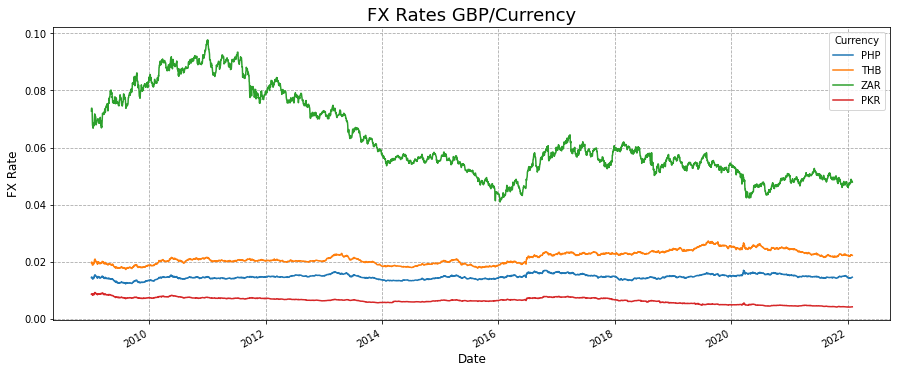

In [18]:
fx_rates_to_gbp.plot()
plt.title('FX Rates GBP/Currency', fontsize = 18)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('FX Rate', fontsize = 12)
plt.legend().set_title('Currency')
plt.grid(color='darkgray', linestyle='dashed')

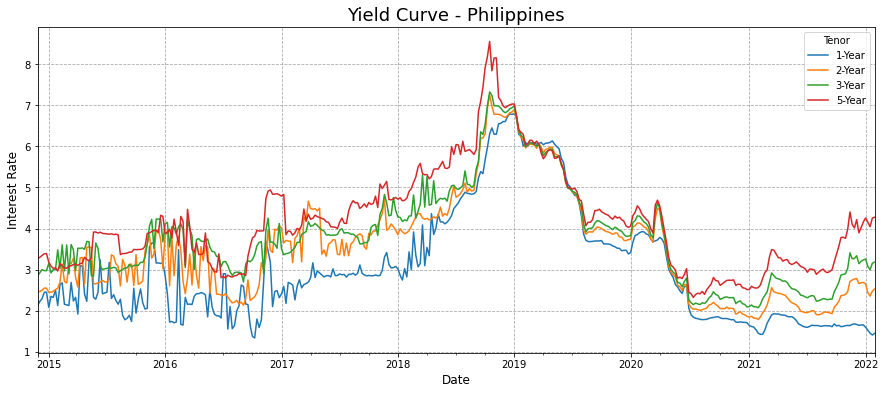

In [19]:
yc_php.resample('W-WED').ffill().loc[:,['1-Year','2-Year','3-Year','5-Year']].plot()
plt.title('Yield Curve - Philippines', fontsize = 18)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Interest Rate', fontsize = 12)
plt.legend().set_title('Tenor')
plt.grid(color='darkgray', linestyle='dashed')

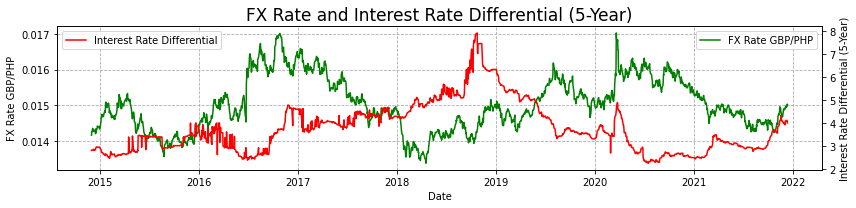

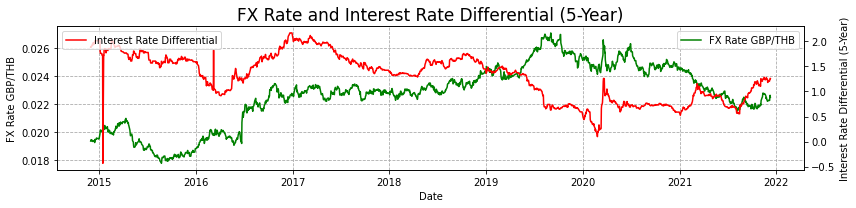

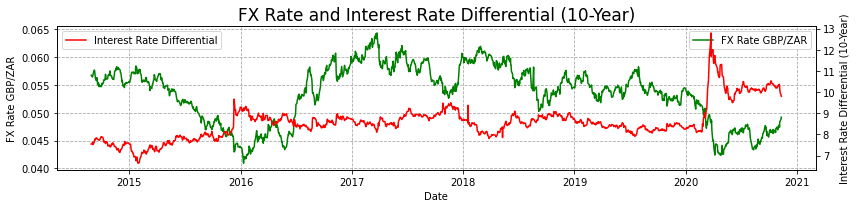

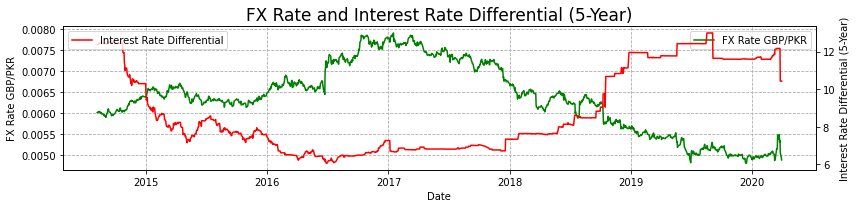

In [20]:
plot_ir_diff_fx(fx_rates_to_gbp,gbr_1m_ois,yc_php, '5-Year', 'PHP')
plot_ir_diff_fx(fx_rates_to_gbp,gbr_1m_ois,yc_thb, '5-Year', 'THB')
plot_ir_diff_fx(fx_rates_to_gbp,gbr_1m_ois,yc_zar, '10-Year', 'ZAR')
plot_ir_diff_fx(fx_rates_to_gbp,gbr_1m_ois,yc_pkr, '5-Year', 'PKR')

In [21]:
php_carry_trade = create_carry_trade(yc_php,yc_gbp,gbr_1m_ois,['1-Year','2-Year','3-Year','4-Year','5-Year'],[1,2,3,4,5],\
                                     usd_to_php_spot,usd_to_gbp_spot,10000000,4/5,5, False)
    

In [22]:
thb_carry_trade = create_carry_trade(yc_thb,yc_gbp,gbr_1m_ois,['1-Year','2-Year','3-Year','4-Year','5-Year'],[1,2,3,4,5],\
                                     usd_to_thb_spot,usd_to_gbp_spot,10000000,4/5,5,False)

In [23]:
weekly_yc_zar = yc_zar.resample('W-WED').ffill().loc[:,['3-Month','6-Month','9-Month','12-Month','10-Year']]
weekly_yc_zar.columns = [0.25,0.50,0.75,1,10]
weekly_yc_zar_zcb = compute_zcb_curve(weekly_yc_zar.T/100).T

yc_zar_interpolated_rates = interpolated_rates(weekly_yc_zar_zcb.dropna().T,10)
yc_zar_interpolated_rates = yc_zar_interpolated_rates.loc[:,[1.0,2.0,3.0,5.0]]
yc_zar_interpolated_rates.columns = [1,2,3,5]

zar_carry_trade = create_carry_trade(yc_zar_interpolated_rates,yc_gbp,gbr_1m_ois,[1,2,3,5],[1,2,3,5],\
                                     usd_to_zar_spot,usd_to_gbp_spot,10000000,4/5,5, True)

In [24]:
weekly_yc_pkr = yc_pkr.resample('W-WED').ffill().loc[:,['3-Month','6-Month','12-Month','3-Year','5-Year']]
weekly_yc_pkr.columns = [0.25,0.50,1,3,5]
weekly_yc_pkr_zcb = compute_zcb_curve(weekly_yc_pkr.T/100).T

yc_pkr_interpolated_rates = interpolated_rates(weekly_yc_pkr_zcb.dropna().T,5)
yc_pkr_interpolated_rates = yc_pkr_interpolated_rates.loc[:,[1.0,2.0,3.0,5.0]]
yc_pkr_interpolated_rates.columns = [1,2,3,5]

pkr_carry_trade = create_carry_trade(yc_pkr_interpolated_rates,yc_gbp,gbr_1m_ois,[1,2,3,5],[1,2,3,5],\
                                     usd_to_zar_spot,usd_to_gbp_spot,10000000,4/5,5, True)

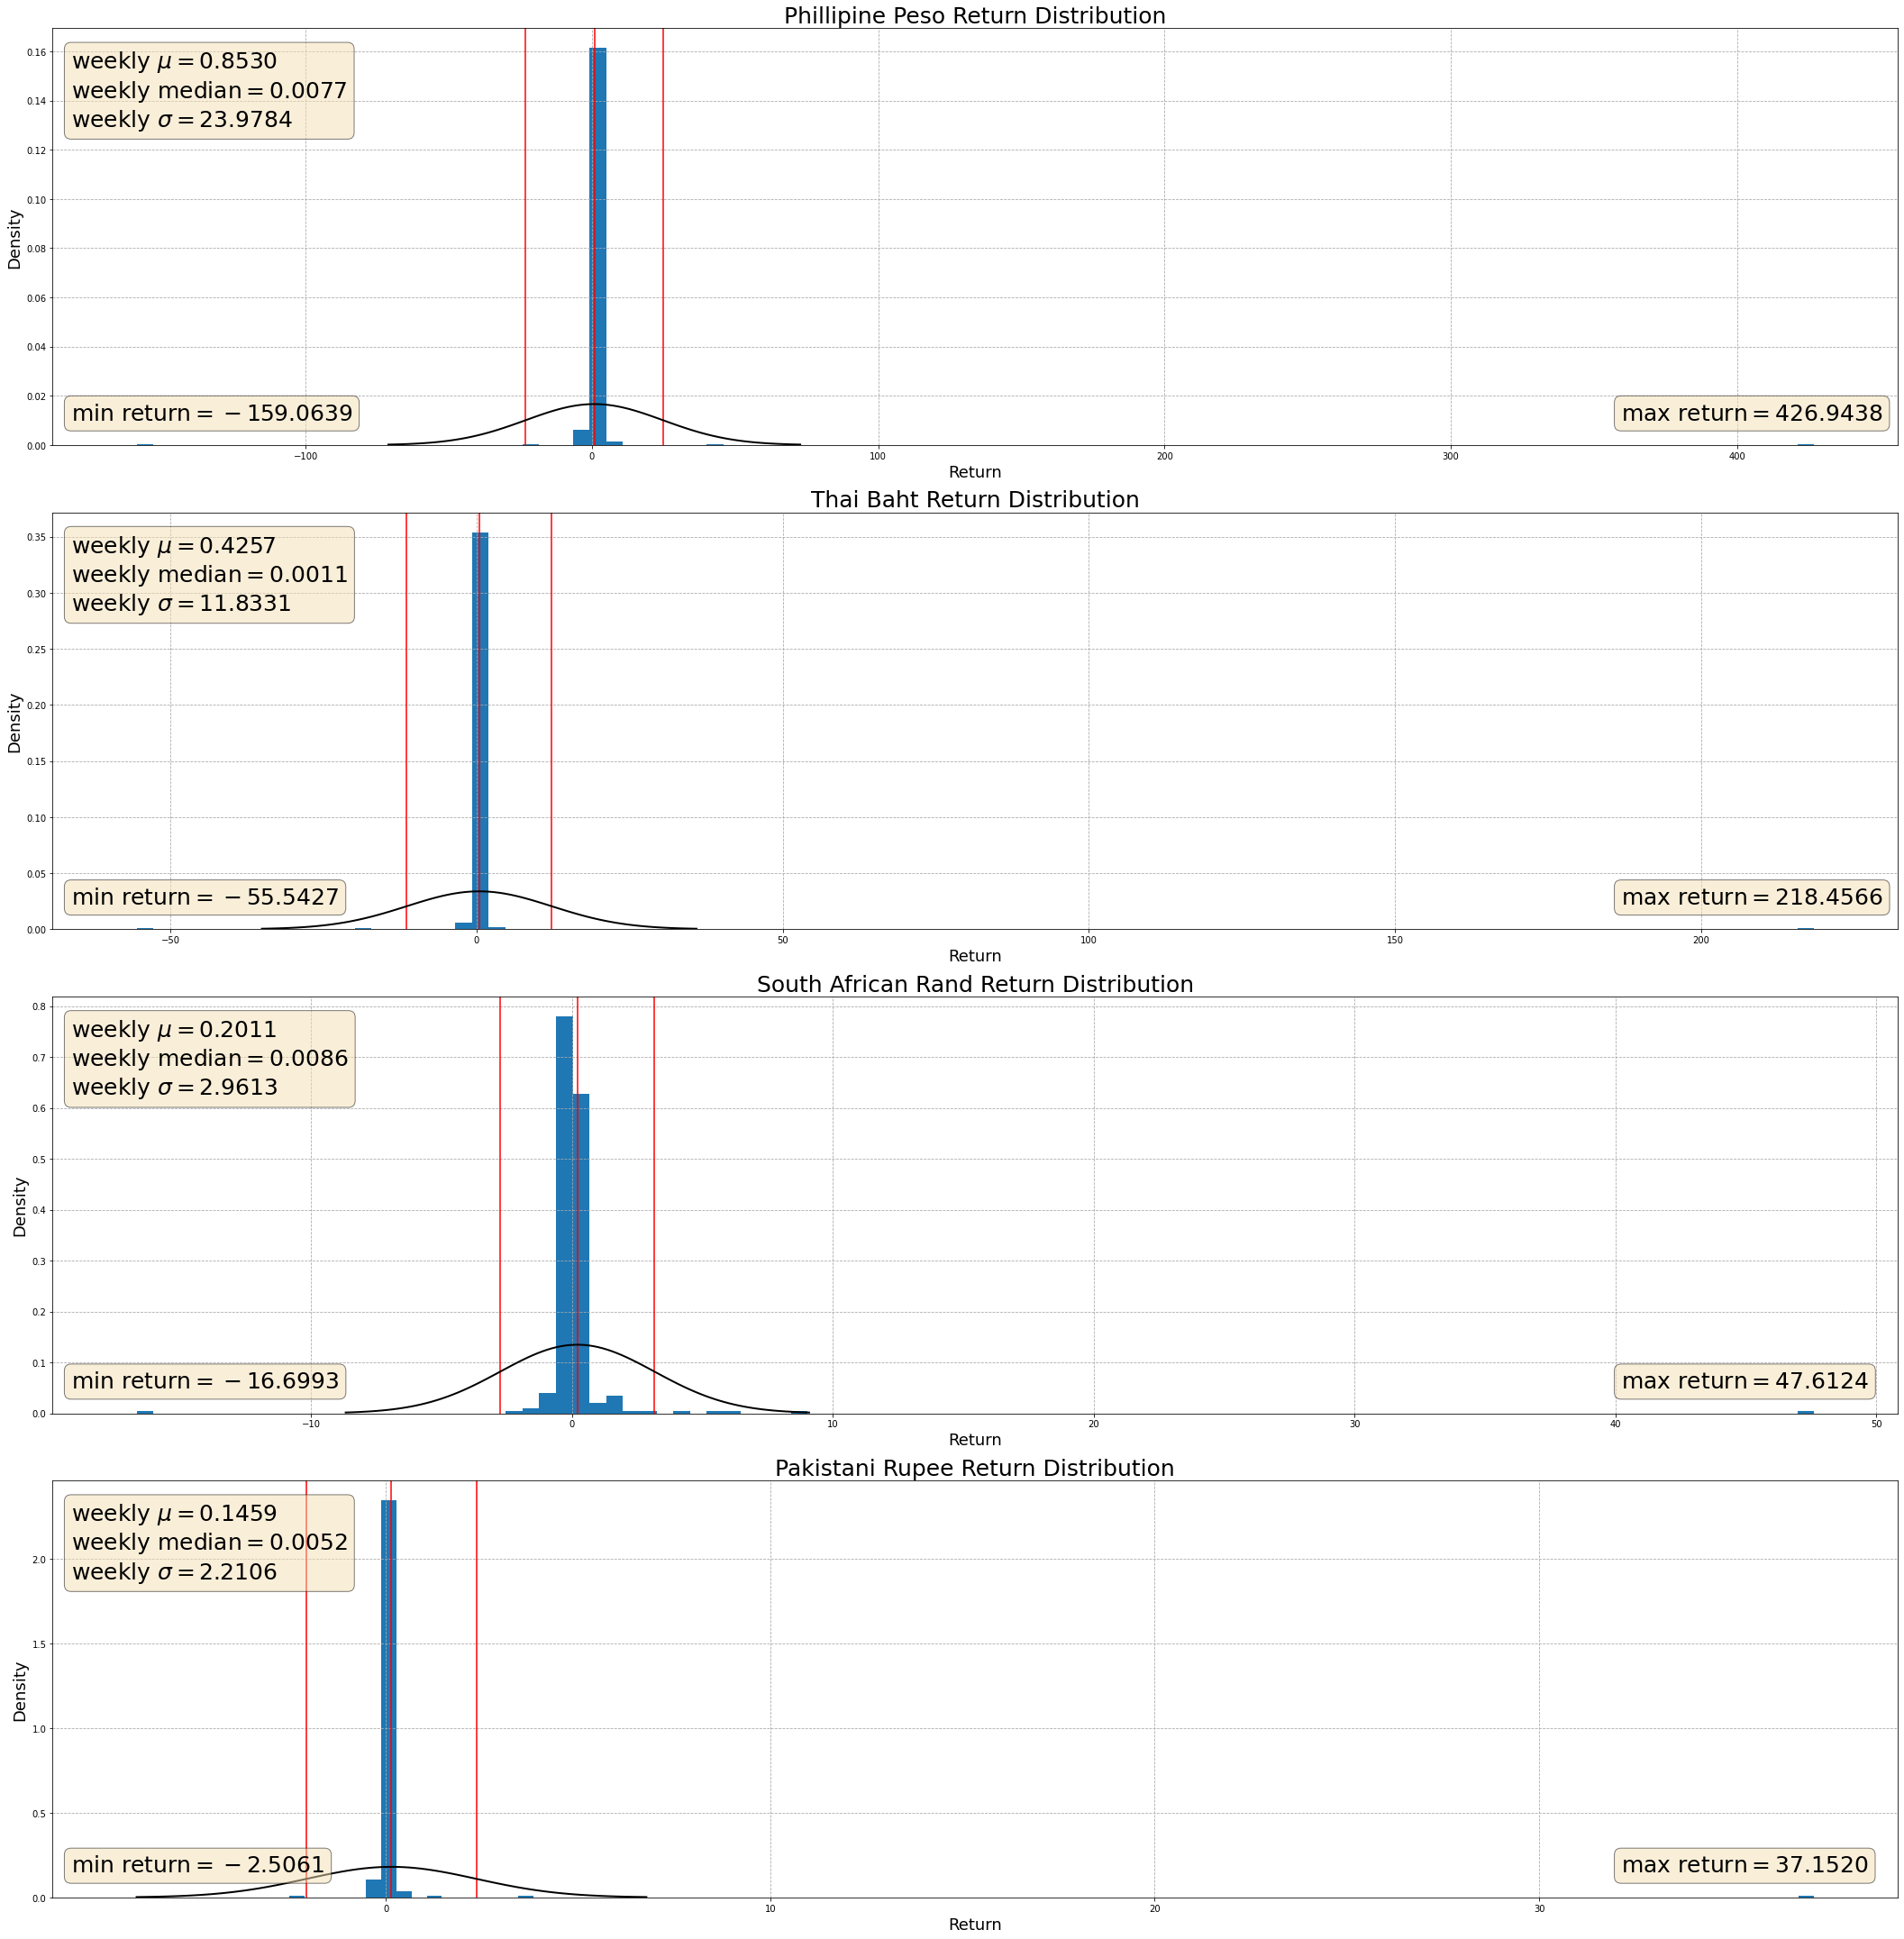

In [25]:
lst = [php_carry_trade,thb_carry_trade,zar_carry_trade,pkr_carry_trade]
dict_map = {0:'Phillipine Peso',1:'Thai Baht',2:'South African Rand',3:'Pakistani Rupee'}
plot_return_distribution(lst,dict_map)


In [26]:
strat_returns = php_carry_trade.loc[:,['weekly_returns']].merge(thb_carry_trade.loc[:,['weekly_returns']].rename(columns = {'weekly_returns':'Thai Baht'}), how = 'inner', left_on = php_carry_trade.index, right_on = thb_carry_trade.index).set_index('key_0')
strat_returns = strat_returns.merge(zar_carry_trade.loc[:,['weekly_returns']].rename(columns = {'weekly_returns':'South African Rand'}), how = 'inner', left_on = strat_returns.index, right_on = zar_carry_trade.index).set_index('key_0')
strat_returns = strat_returns.merge(pkr_carry_trade.loc[:,['weekly_returns']].rename(columns = {'weekly_returns':'Pakistani Rupee'}), how = 'inner', left_on = strat_returns.index, right_on = pkr_carry_trade.index).set_index('key_0')
strat_returns = strat_returns.rename(columns = {'weekly_returns':'Philippine Peso'})
strat_returns.index.name = 'Date'
return_summary = performance_summary(strat_returns.fillna(0))
return_summary['Start Date'] = strat_returns.fillna(0).index.min()
return_summary['End Date'] = strat_returns.fillna(0).index.max()
return_summary

,Mean,Volatility,Sharpe Ratio,Skewness,Excess Kurtosis,VaR (0.05),CVaR (0.05),Min,Max,Max Drawdown,Peak,Bottom,Recovery,Start Date,End Date
Philippine Peso,61.019033,202.116650,0.301900,12.531677,205.038615,-0.843468,-14.706015,-159.063933,426.943750,-458.367070,2017-01-11,2020-03-18,NaT,2014-12-03,2020-04-01
Thai Baht,30.442543,99.742016,0.305213,14.485994,233.815781,-0.313311,-5.872336,-55.542672,218.456621,-60.188181,2014-12-17,2015-04-15,2015-05-06,2014-12-03,2020-04-01
South African Rand,10.509224,22.956643,0.457786,11.997788,188.666114,-0.406261,-2.037939,-16.699295,47.612384,-2.739681,2015-01-28,2015-04-01,2015-05-13,2014-12-03,2020-04-01
Pakistani Rupee,0.408019,0.558758,0.730225,1.391708,7.946905,-0.102232,-0.145186,-0.246297,0.516745,-0.624234,2015-04-29,2016-01-06,2016-03-23,2014-12-03,2020-04-01


In [27]:
Q1 = strat_returns.quantile(0.25)
Q3 = strat_returns.quantile(0.75)
IQR = Q3 - Q1

strat_returns_mod = strat_returns[~((strat_returns < (Q1 - 3 * IQR)) |(strat_returns > (Q3 + 3 * IQR))).any(axis=1)]

strat_returns_mod
return_summary_mod = performance_summary(strat_returns_mod.fillna(0))
return_summary_mod['Start Date'] = strat_returns_mod.fillna(0).index.min()
return_summary_mod['End Date'] = strat_returns_mod.fillna(0).index.max()
return_summary_mod

,Mean,Volatility,Sharpe Ratio,Skewness,Excess Kurtosis,VaR (0.05),CVaR (0.05),Min,Max,Max Drawdown,Peak,Bottom,Recovery,Start Date,End Date
Philippine Peso,1.697907,2.108856,0.805132,0.264601,2.108981,-0.377436,-0.614136,-1.045801,0.925575,-1.006458,2017-01-11,2020-03-18,NaT,2015-01-14,2020-04-01
Thai Baht,0.001315,0.492054,0.002673,-0.786388,4.805629,-0.116539,-0.196706,-0.266700,0.252192,-0.799454,2015-01-21,2016-04-20,NaT,2015-01-14,2020-04-01
South African Rand,-0.163133,1.060780,-0.153786,-0.073466,2.634099,-0.278147,-0.363985,-0.492765,0.528160,-0.986227,2015-02-18,2017-11-08,NaT,2015-01-14,2020-04-01
Pakistani Rupee,0.106643,0.383343,0.278191,0.482343,2.978095,-0.086303,-0.114028,-0.168556,0.217929,-0.345909,2015-09-30,2016-02-24,2017-03-15,2015-01-14,2020-04-01


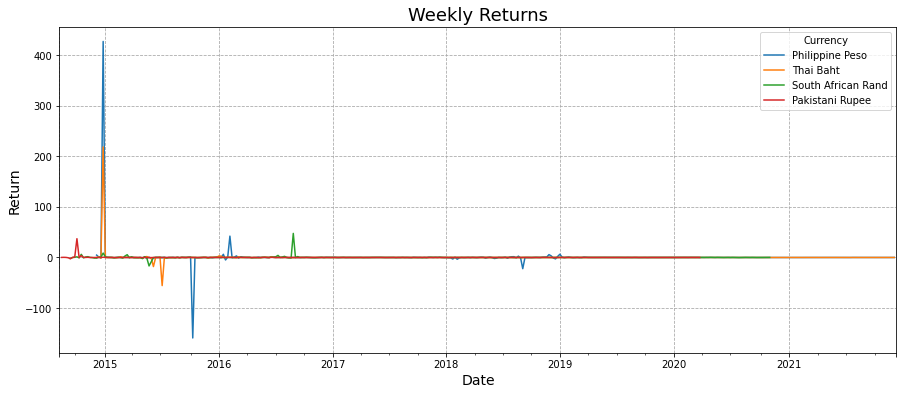

In [28]:
ax = php_carry_trade.loc[:,['weekly_returns']].rename(columns={'weekly_returns':'Philippine Peso'}).plot()
thb_carry_trade.loc[:,['weekly_returns']].rename(columns={'weekly_returns':'Thai Baht'}).plot(ax = ax)
zar_carry_trade.loc[:,['weekly_returns']].rename(columns={'weekly_returns':'South African Rand'}).plot(ax = ax)
pkr_carry_trade.loc[:,['weekly_returns']].rename(columns={'weekly_returns':'Pakistani Rupee'}).plot(ax = ax)

plt.title('Weekly Returns', fontsize = 18)
plt.ylabel('Return', fontsize = 14)
plt.xlabel('Date', fontsize = 14)
plt.legend().set_title('Currency')
plt.grid(color='darkgray', linestyle='dashed')

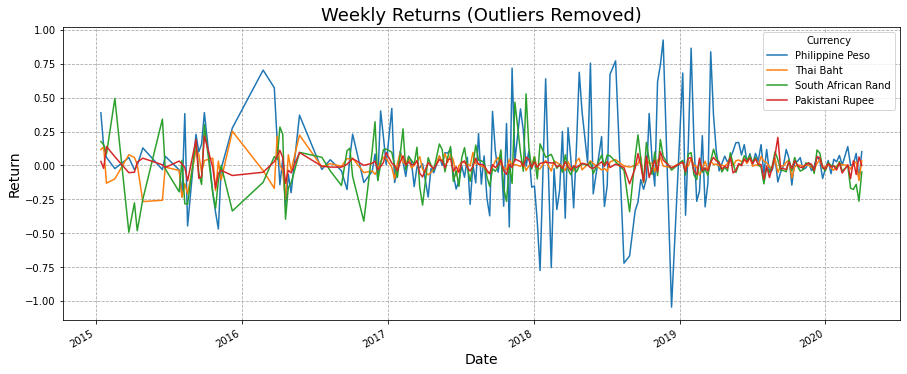

In [29]:
strat_returns_mod.fillna(0).plot()
plt.title('Weekly Returns (Outliers Removed)', fontsize = 18)
plt.ylabel('Return', fontsize = 14)
plt.xlabel('Date', fontsize = 14)
plt.legend().set_title('Currency')
plt.grid(color='darkgray', linestyle='dashed')

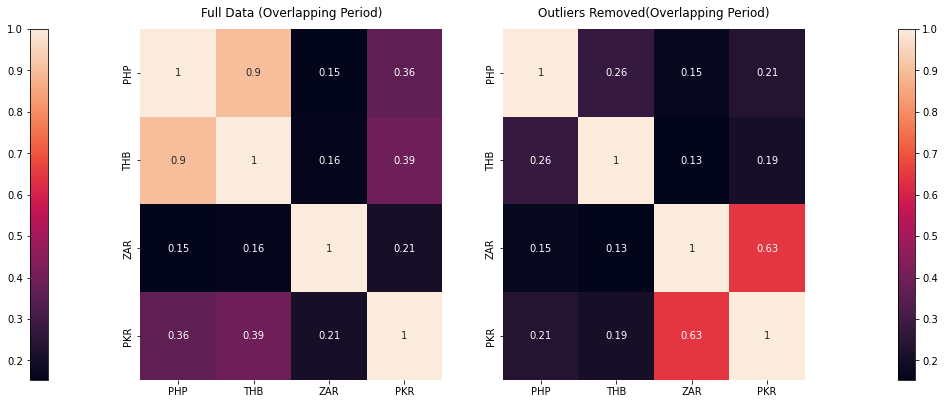

In [30]:
fig, (ax,ax2) = plt.subplots(ncols=2)

strat_returns.columns = ['PHP','THB','ZAR','PKR']
strat_returns_mod.columns = ['PHP','THB','ZAR','PKR']

fig.subplots_adjust(wspace=0.01)
fig.tight_layout(pad=3)
sns.heatmap(strat_returns.fillna(0).corr(), ax=ax, cbar=False, annot = True).set_title('Full Data (Overlapping Period)', fontdict={'fontsize':12}, pad=12);

fig.colorbar(ax.collections[0], ax=ax,location="left", use_gridspec=False, pad=0.2)

sns.heatmap(strat_returns_mod.fillna(0).corr(), ax=ax2, cbar=False, annot = True).set_title('Outliers Removed(Overlapping Period)', fontdict={'fontsize':12}, pad=12);

fig.colorbar(ax.collections[0],ax=ax2,location="right", use_gridspec=False, pad=0.2)

fig.set_figwidth(15)



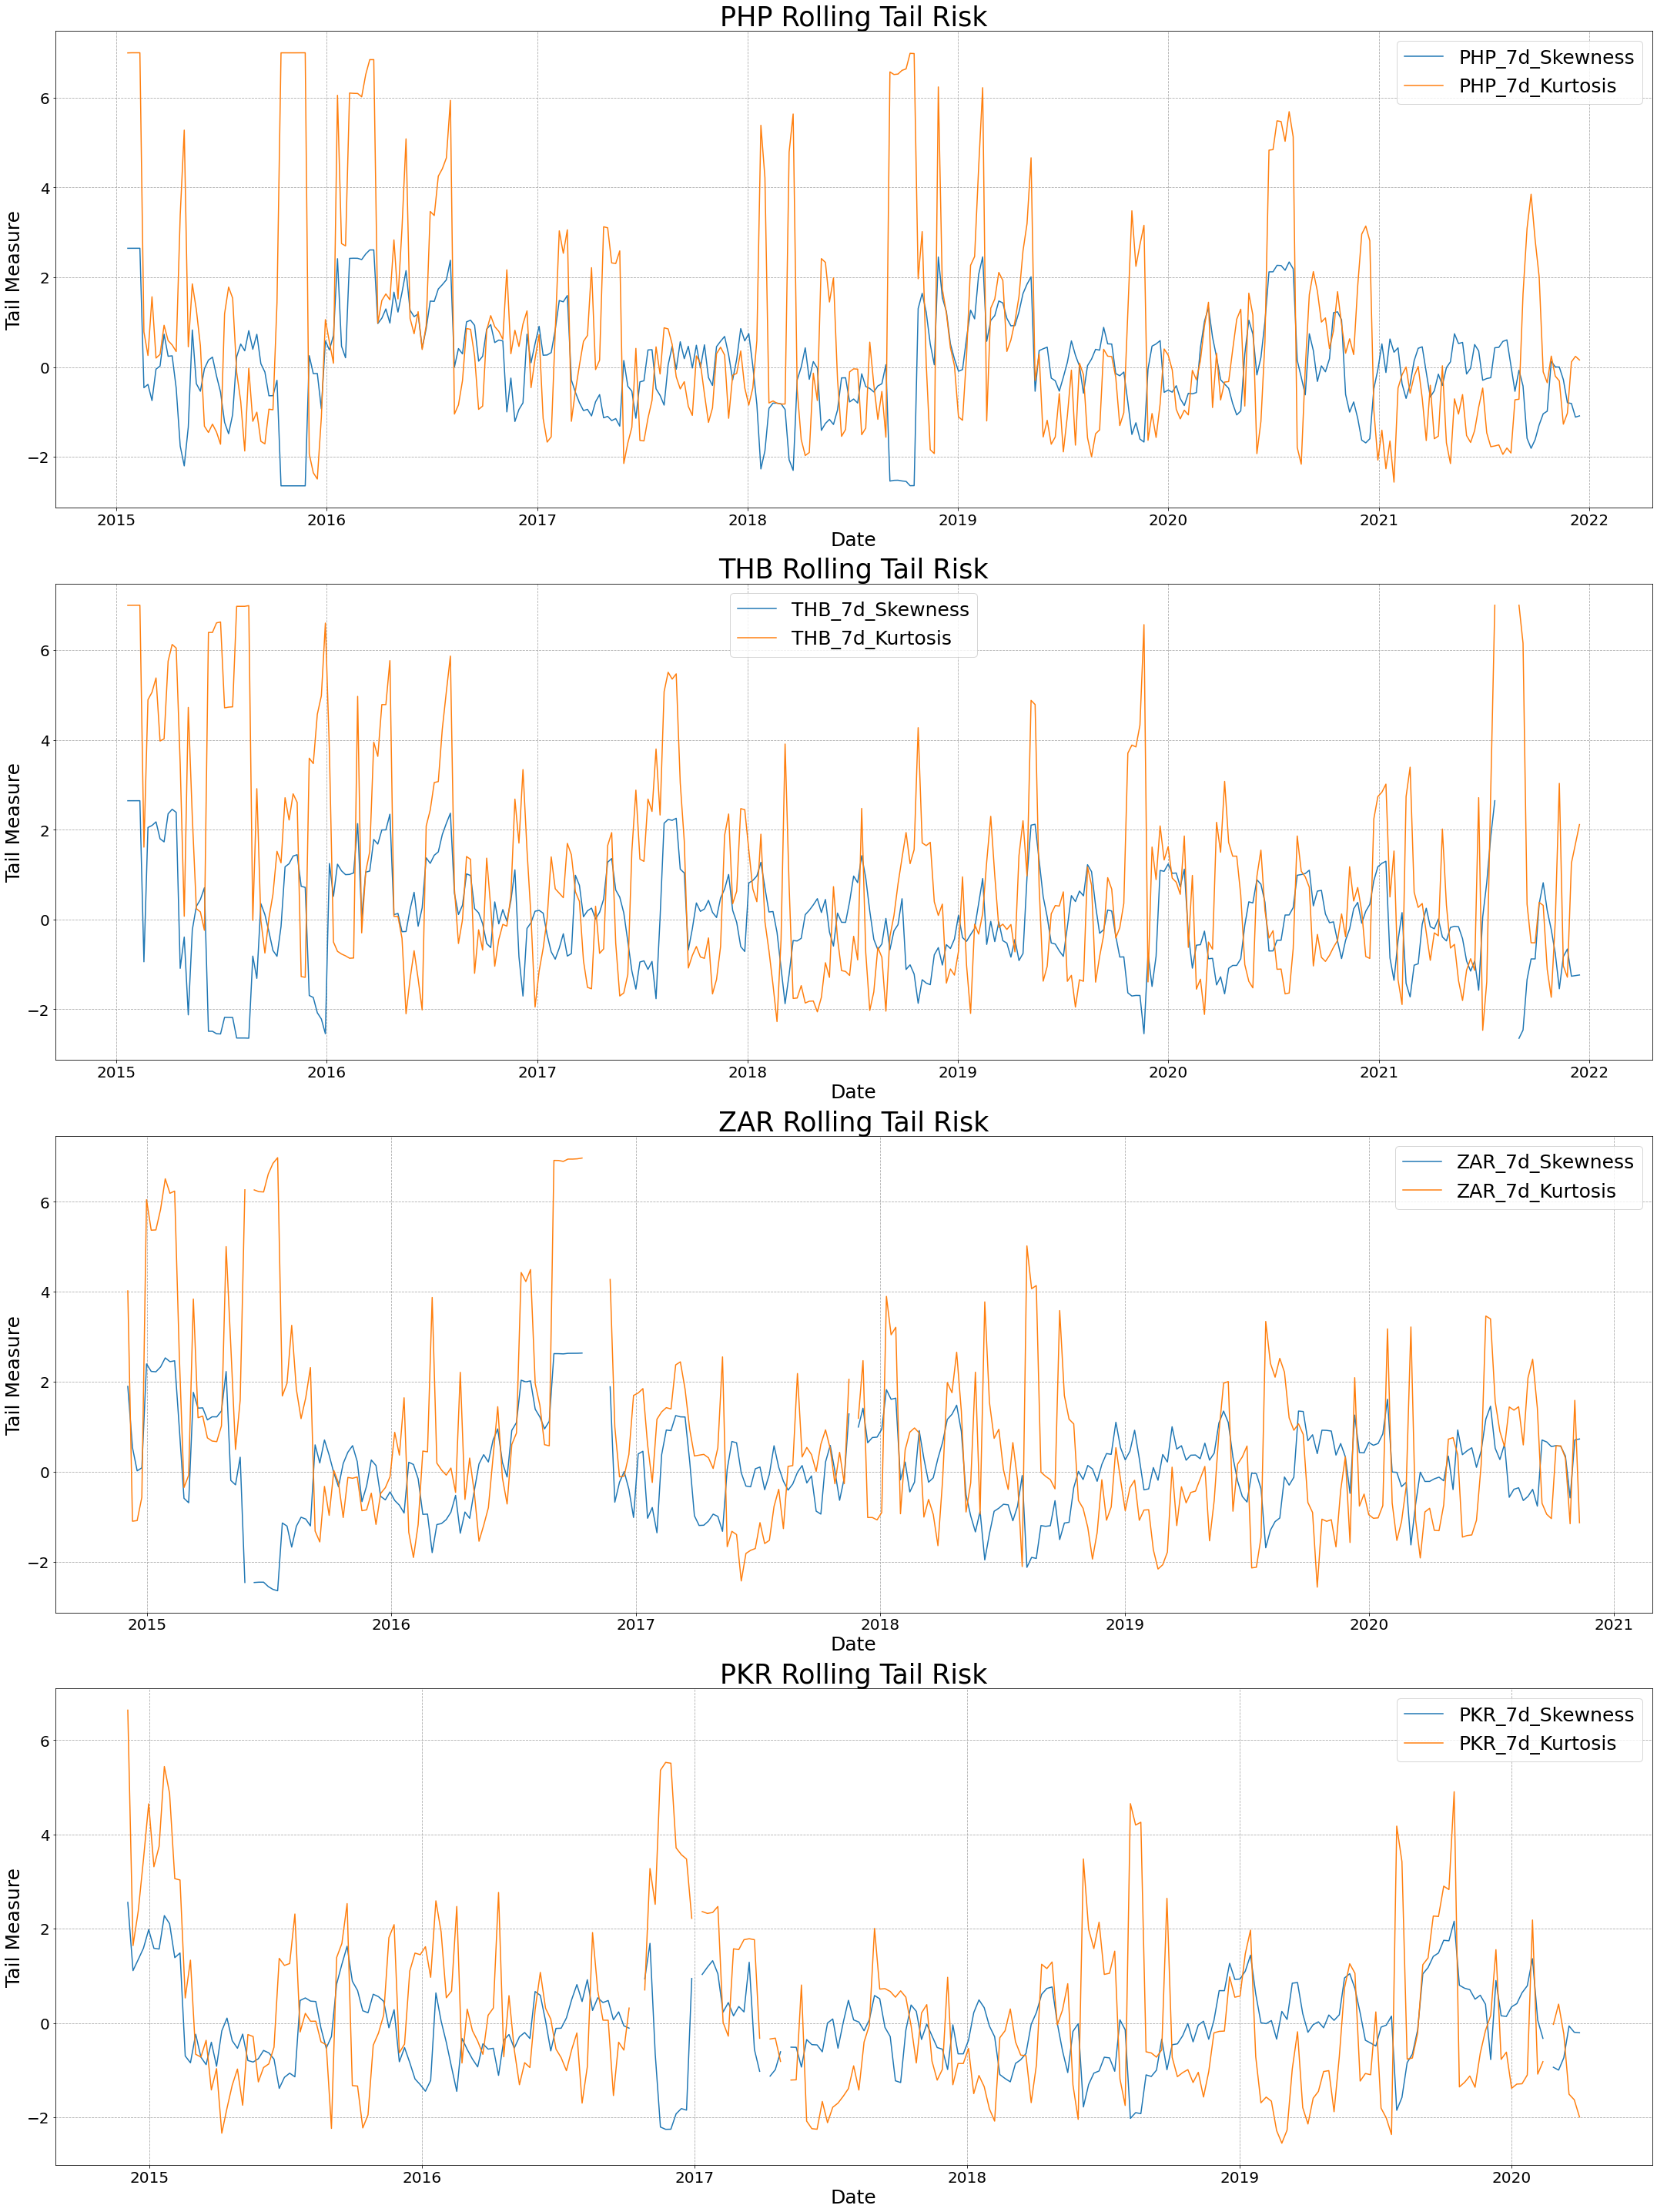

In [31]:
plot_rolling_tail_risk(7,['PHP','THB','ZAR','PKR'],[php_carry_trade,thb_carry_trade,zar_carry_trade,pkr_carry_trade],'Rolling Tail Risk Analysis')

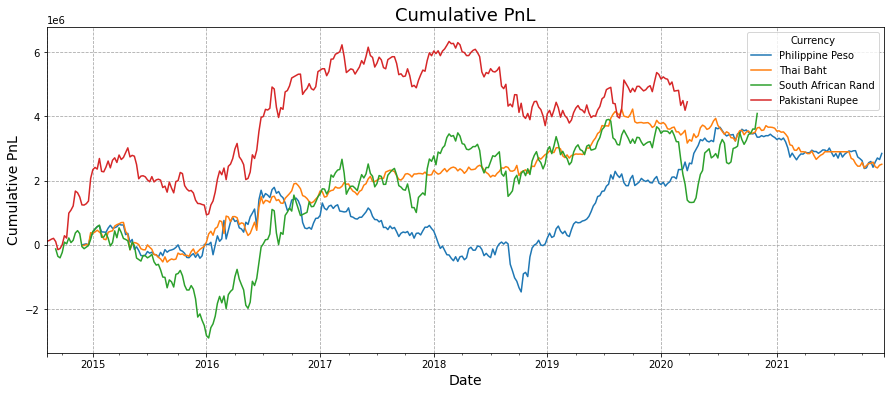

In [32]:
ax = php_carry_trade.loc[:,['cum_pnl_usd']].rename(columns={'cum_pnl_usd':'Philippine Peso'}).plot()
thb_carry_trade.loc[:,['cum_pnl_usd']].rename(columns={'cum_pnl_usd':'Thai Baht'}).plot(ax = ax)
zar_carry_trade.loc[:,['cum_pnl_usd']].rename(columns={'cum_pnl_usd':'South African Rand'}).plot(ax = ax)
pkr_carry_trade.loc[:,['cum_pnl_usd']].rename(columns={'cum_pnl_usd':'Pakistani Rupee'}).plot(ax = ax)


plt.title('Cumulative PnL', fontsize = 18)

#plt.axes().xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 6)))

plt.ylabel('Cumulative PnL', fontsize = 14)
plt.xlabel('Date', fontsize = 14)
plt.legend().set_title('Currency')
plt.grid(color='darkgray', linestyle='dashed')

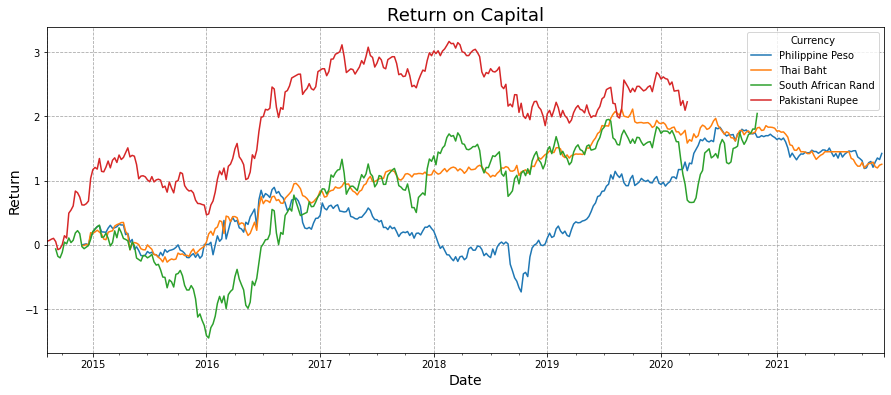

In [33]:
ax = php_carry_trade.loc[:,['return_on_capital']].rename(columns={'return_on_capital':'Philippine Peso'}).plot()
thb_carry_trade.loc[:,['return_on_capital']].rename(columns={'return_on_capital':'Thai Baht'}).plot(ax = ax)
zar_carry_trade.loc[:,['return_on_capital']].rename(columns={'return_on_capital':'South African Rand'}).plot(ax = ax)
pkr_carry_trade.loc[:,['return_on_capital']].rename(columns={'return_on_capital':'Pakistani Rupee'}).plot(ax = ax)


plt.title('Return on Capital', fontsize = 18)

#plt.axes().xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 6)))

plt.ylabel('Return', fontsize = 14)
plt.xlabel('Date', fontsize = 14)
plt.legend().set_title('Currency')
plt.grid(color='darkgray', linestyle='dashed')